# Importing Packages

In [1]:
import os
import sys
import random
import warnings
from zipfile import ZipFile

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2

from tqdm import notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K

import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [2]:
for dirname, _, filenames in os.walk('../input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../input/tgs-salt-identification-challenge/sample_submission.csv
../input/tgs-salt-identification-challenge/depths.csv
../input/tgs-salt-identification-challenge/test.zip
../input/tgs-salt-identification-challenge/flamingo.zip
../input/tgs-salt-identification-challenge/train.zip
../input/tgs-salt-identification-challenge/competition_data.zip
../input/tgs-salt-identification-challenge/train.csv


In [3]:
ZipFile('../input/tgs-salt-identification-challenge/train.zip').extractall()
ZipFile('../input/tgs-salt-identification-challenge/test.zip').extractall('test')

# Data Exploration

In [4]:
# Set some parameters
im_width = 128
im_height = 128
im_chan = 1
path_train = '../working/'
path_test = '../working/test/'

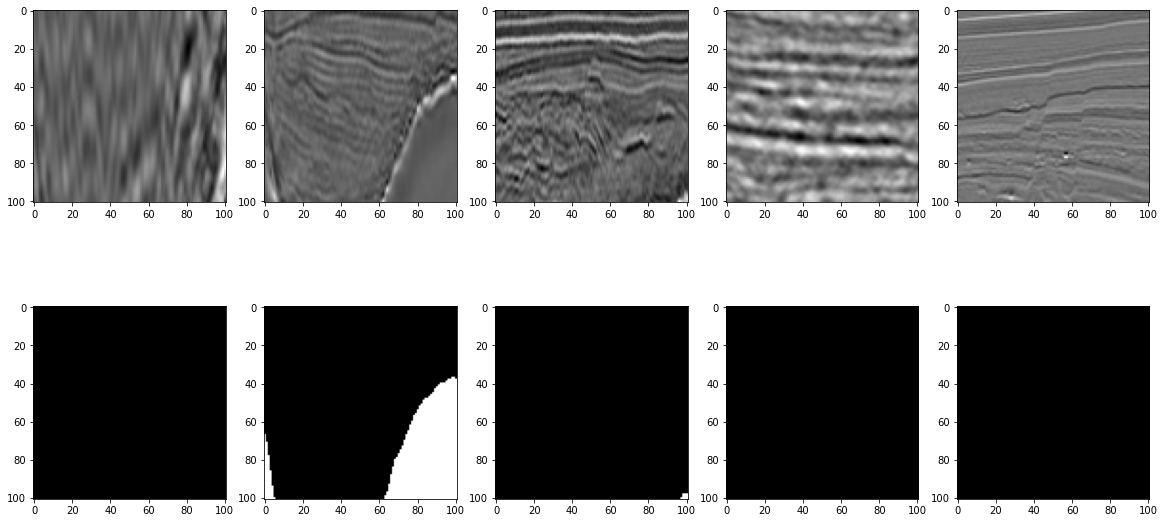

In [5]:
ids= ['1f1cc6b3a4','5b7c160d0d','6c40978ddf','7dfdf6eeb8','7e5a6e5013']

row = 2
column = 5
plt.figure(figsize=(20,10))
for j, img_name in enumerate(ids):
    q = column+j+1
    img = load_img('../working/images/' + img_name + '.png')
    img_mask = load_img('../working//masks/' + img_name + '.png')
    #print("Image of j : {} j : {} q : {}\n\n".format(j,j, q))
    plt.subplot(row, column,j+1)
    plt.imshow(img)
    plt.subplot(row, column,q)
    plt.imshow(img_mask)
plt.show()

We have many examples without salt, as you can see by the masks that are entirely dark. That's great, an algorithm we build will then know that patches exist entirely without salt. Talk about biasing your data.

We can draw heavily on other work, instead of regurgitating the geophysics work that has been done before. I mentioned that seismic is kind of like ultrasound. So I had a look at https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277

Let's throw a Unet at our data. I am blatanly stealing from Ketil at this point. All credit goes to him and his nice code.
First we'll need to get our data into a shape that works for U-Nets. That means, it should be a power of 2. Let's do it quick and dirty for now, but eventually, consider aliasing and all that fun.

    os.walk('C:\dir1\dir2\startdir').next()[0] # returns 'C:\dir1\dir2\startdir'
    os.walk('C:\dir1\dir2\startdir').next()[1] # returns all the dirs in 'C:\dir1\dir2\startdir'
    os.walk('C:\dir1\dir2\startdir').next()[2] # returns all the files in 'C:\dir1\dir2\startdir'
    
    Here, 0,1,2 implies successively current_path, directories in current_path, files in current_path

In [6]:
train_ids = next(os.walk(path_train+"images"))[2]
test_ids = next(os.walk(path_test+"images"))[2]

np.zeros returns a new array of given shape and type, filled with zeros.

In [7]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.uint8)

# Since our masked image contains two colors, we'll use bool in this scenario
# and that's why we've used sigmoid later as an activation function
Y_train = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.bool) 
print('Getting and resizing train images and masks ... ')

# here total parameter in tqdm is arbitrary
for n, id_ in notebook.tqdm(enumerate(train_ids), total=len(train_ids)):
    
    # images
    img = img_to_array(load_img(path_train + '/images/' + id_))[:,:,1]
    X_train[n] = resize(img, (128, 128, 1), mode='constant', preserve_range=True)
    
    # masks
    mask = img_to_array(load_img(path_train + '/masks/' + id_))[:,:,1]
    Y_train[n] = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)
    
print('Finished 😃')

Getting and resizing train images and masks ... 



Finished 😃


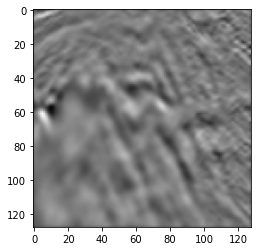

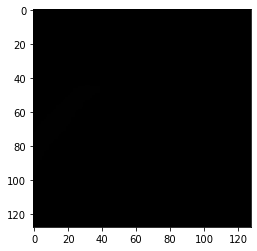

In [8]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
plt.imshow(np.dstack((X_train[ix],X_train[ix],X_train[ix])))
plt.show()

# As I've already stored the value of Y_train as boolean, to plot that for now,
# I've to squeeze it to float or uint8 value
tmp = np.squeeze(Y_train[ix]).astype(np.uint8)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()

# Train Model

In [9]:
# Build U-Net model
inputs = Input((im_height, im_width, im_chan))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.MeanIoU(num_classes=2)])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 8)  80          lambda_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 8)  584         conv2d_1[0][0]                   
____________________________________________________________________________________________

In [10]:
reduce = ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1)
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-tgs-salt-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=8, epochs=50, 
                    callbacks=[earlystopper, checkpointer, reduce])

Train on 3600 samples, validate on 400 samples
Epoch 1/50
3600/3600 [==============================] - 13s 4ms/step - loss: 0.5472 - mean_io_u: 0.3764 - val_loss: 0.4654 - val_mean_io_u: 0.3740

Epoch 00001: val_loss improved from inf to 0.46539, saving model to model-tgs-salt-1.h5
Epoch 2/50
3600/3600 [==============================] - 8s 2ms/step - loss: 0.4656 - mean_io_u: 0.3743 - val_loss: 0.3861 - val_mean_io_u: 0.3741

Epoch 00002: val_loss improved from 0.46539 to 0.38606, saving model to model-tgs-salt-1.h5
Epoch 3/50
3600/3600 [==============================] - 8s 2ms/step - loss: 0.4133 - mean_io_u: 0.3743 - val_loss: 0.3415 - val_mean_io_u: 0.3743

Epoch 00003: val_loss improved from 0.38606 to 0.34154, saving model to model-tgs-salt-1.h5
Epoch 4/50
3600/3600 [==============================] - 7s 2ms/step - loss: 0.3466 - mean_io_u: 0.3746 - val_loss: 0.3140 - val_mean_io_u: 0.3743

Epoch 00004: val_loss improved from 0.34154 to 0.31401, saving model to model-tgs-salt-1.h5


# Test Data

shape[0] means row and shape[1] means column

In [11]:
# Get and resize test images
X_test = np.zeros((len(test_ids), im_height, im_width, im_chan), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')

for n, id_ in notebook.tqdm(enumerate(test_ids), total=len(test_ids)):
    img = img_to_array(load_img(path_test + '/images/' + id_))[:,:,1]
    X_test[n] = resize(img, (128, 128, 1), mode='constant', preserve_range=True)
    
    sizes_test.append([img.shape[0], img.shape[1]]) 
    

print('Done!')

Getting and resizing test images ... 



Done!


**0.9** ==> that's a manual way to create both the training and validation sets. It should be select 90% example for training, leave the others for validation

for each pixel we get a value between 0 to 1.<br>
0 represents no salt and 1 represents salt.<br>
We take 0.5 as the threshold to decide whether to classify a pixel as 0 or 1.

In [12]:
# Predict on train, val and test
model.load_weights('model-tgs-salt-1.h5')
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

18000/18000 [==============================] - 6s 318us/step


In [13]:
# Create list of upsampled test masks
preds_test_upsampled = []
for i in tnrange(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]),#image 
                                       (sizes_test[i][0], sizes_test[i][1]), #output(row, column)
                                       mode='constant', preserve_range=True))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  This is separate from the ipykernel package so we can avoid doing imports until


it's (101,101), cz we didn't change the dimension on test set images any further.

In [14]:
preds_test_upsampled[0].shape

(101, 101)

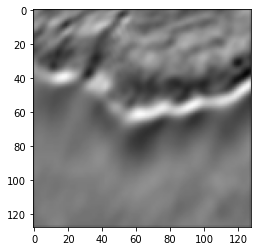

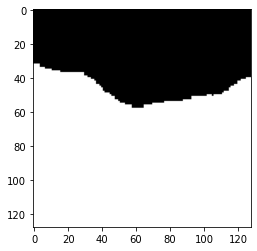

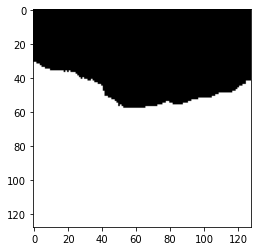

In [33]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
#ix = 50
plt.imshow(np.dstack((X_train[ix],X_train[ix],X_train[ix])))
plt.show()
tmp = np.squeeze(Y_train[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()
tmp = np.squeeze(preds_train_t[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()

# Prepare Submission

In [16]:
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

In [30]:
%%time
# here -4 is used to avoid the last four words ".png"
pred_dict = { 

    fn[:-4] : # All but the last four characters
                 RLenc(np.round(preds_test_upsampled[i]))
    
    for i,fn in notebook.tqdm(enumerate(test_ids), 
                                           total = len(test_ids))
}


CPU times: user 10min 59s, sys: 3.76 s, total: 11min 3s
Wall time: 11min 5s


In [18]:
print(type(pred_dict))

<class 'dict'>


In [22]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('seismicSalatDetectionSubmission.csv')

In [20]:
sub.head()

,rle_mask
id,
cd90c05864,
3b3647008a,86 5 188 2
95fc6d05a6,
ade356fe0a,
03422321bb,1 2 48 56 156 48 268 37 373 32 475 31 576 32 6...
